# MLIB Lab 2

## 1. Exploratory data analysis

In [1]:
import findspark
findspark.init("/home/alumno/spark-3.2.2-bin-hadoop2.7")
from pyspark import SparkContext, SparkConf
conf=SparkConf().setAppName("intro").setMaster("local")
sc = SparkContext(conf=conf)
from pyspark.sql import SparkSession
spark=SparkSession(sc)

In [2]:
! ls housing

data_description.txt  housing_all.csv


In [3]:
#First, we read our input. Download housing dataset files: housing_all.csv from Virtual Campus in your local instance.
housing_csv="/home/alumno/Descargas/housing/housing_all.csv"
housingDF=spark.read.option("header",True).csv(housing_csv, inferSchema=True)
housingDF.printSchema()
total = housingDF.count()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemod/Add: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |

In [4]:
print(f"Total: {total}")

Total: 2930


## 2. Plotting summary data views using Pandas

In [5]:
#we will convert Spark DataFrames to Pandas and then use its plotting tools.
import matplotlib.pyplot as plt
import seaborn as sns
pandasDF=housingDF.toPandas()

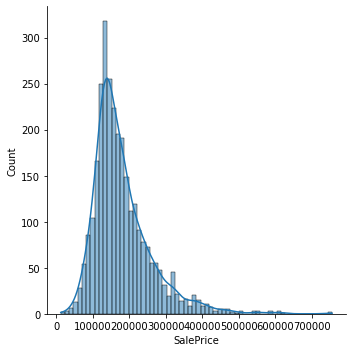

In [6]:
#Our first plot will be the distribution of housing sale price among all records
sns.displot(data=pandasDF['SalePrice'], kde=True)

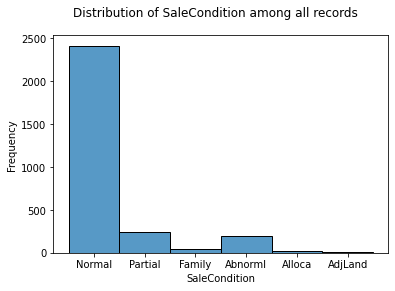

In [7]:
#We also plot the distribution of the conditions of sale among all records
plt.suptitle(f"Distribution of SaleCondition among all records")
plt.ylabel("Frequency")
sns.histplot(pandasDF['SaleCondition']);

In [8]:
#Summary statistics for "MSSubClass", "PoolArea", "YearBuilt" columns. We want to use 2 as maximum number of decimal places:
from pyspark.sql.functions import round
pandasDF[["MSSubClass","PoolArea","YearBuilt"]].describe().round(2)

,MSSubClass,PoolArea,YearBuilt
count,2930.00,2930.00,2930.00
mean,57.39,2.24,1971.36
std,42.64,35.60,30.25
min,20.00,0.00,1872.00
25%,20.00,0.00,1954.00
50%,50.00,0.00,1973.00
75%,70.00,0.00,2001.00
max,190.00,800.00,2010.00


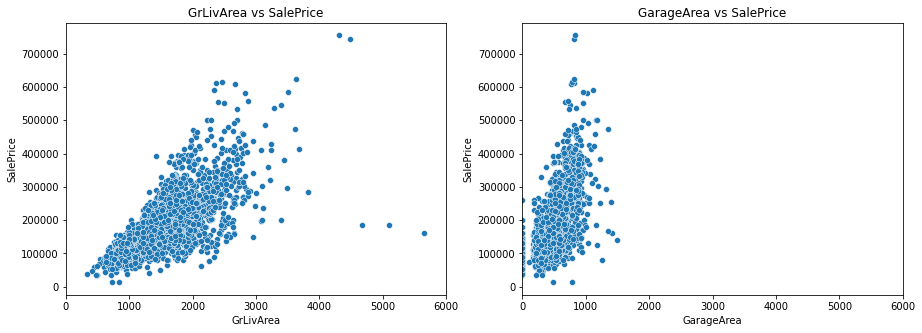

In [9]:
#eliminate some outlier points of the dataset. In the next graph we plot a comparison between the ground living area and garage area.
fig1, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0,6000)
sns.scatterplot(data=pandasDF, ax=axes[0], x="GrLivArea", y="SalePrice")
axes[0].set_title("GrLivArea vs SalePrice")
sns.scatterplot(data=pandasDF, ax=axes[1], x="GarageArea", y="SalePrice")
axes[1].set_title("GarageArea vs SalePrice");

<Axes: title={'center': 'GrvLivArea vs SalePrice'}, xlabel='GrLivArea', ylabel='SalePrice'>

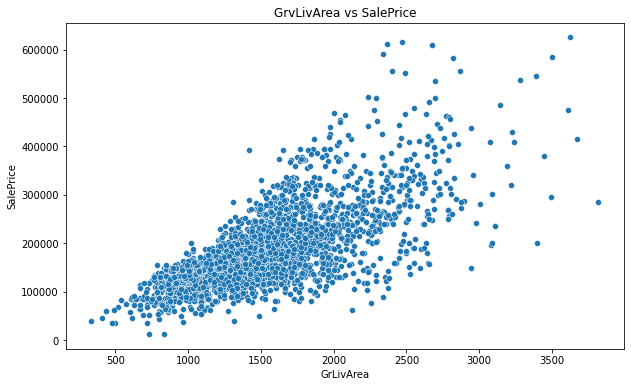

In [10]:
#We can use the output of these plots to remove outlier points like those values higher than 4.000 in
#GrLiveArea and those above 7.000.000 in SalePrice.
pandasDF2 = pandasDF.loc[(pandasDF["GrLivArea"] < 4000) & (pandasDF["SalePrice"] < 7000000)]
fig2 = plt.figure(figsize=(10,6))
axes = fig2.add_subplot()
axes.set_title("GrvLivArea vs SalePrice")
sns.scatterplot(data=pandasDF2, ax=axes, x="GrLivArea", y="SalePrice")

### Exercise 1: 
### Create similar scatter-plots for TotalBsmtSF vs SalePrice and 1stFlrSF vs SalePrice.

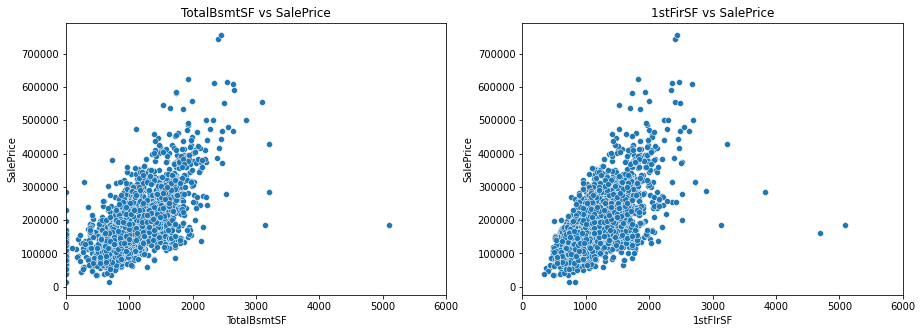

In [11]:
fig3, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0,6000)
sns.scatterplot(data=pandasDF, ax=axes[0], x="TotalBsmtSF", y="SalePrice")
axes[0].set_title("TotalBsmtSF vs SalePrice")
sns.scatterplot(data=pandasDF, ax=axes[1], x="1stFlrSF", y="SalePrice")
axes[1].set_title("1stFirSF vs SalePrice");

### Exercise 2: 
### Do you see any outliers from GarageArea vs SalePrice, can you remove them?

We can see some outlier points like those values hgher than 700000 in SalePrice

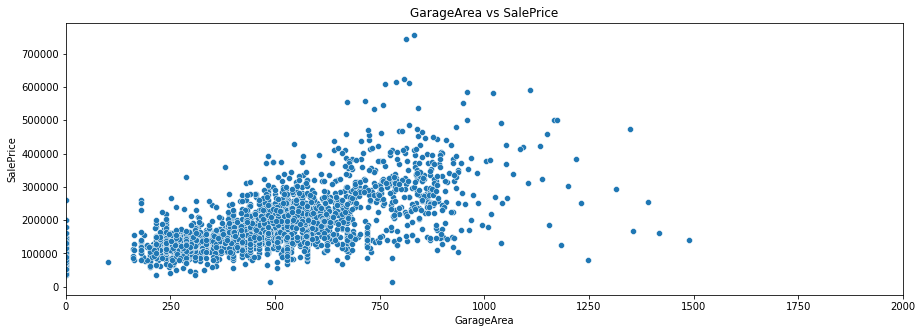

In [12]:
fig4, axes = plt.subplots(1, sharex=True, figsize=(15,5))
axes.set_xlim(0,2000)

sns.scatterplot(data=pandasDF, ax=axes, x="GarageArea", y="SalePrice")
axes.set_title("GarageArea vs SalePrice");

<Axes: title={'center': 'GarageArea vs SalePrice'}, xlabel='GarageArea', ylabel='SalePrice'>

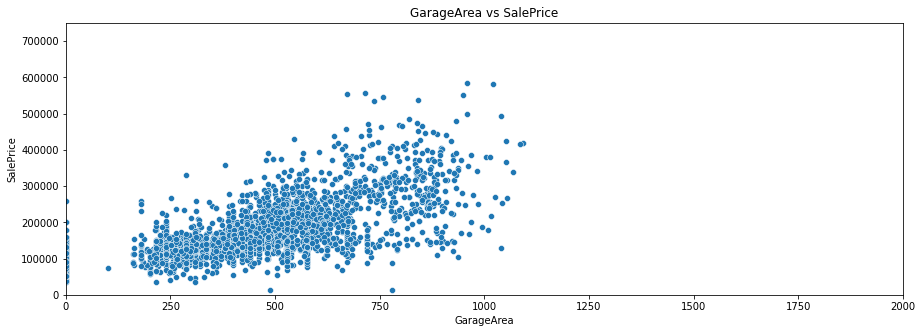

In [13]:
pandasDF5 = pandasDF.loc[(pandasDF["GarageArea"] < 1100) & (pandasDF["SalePrice"] < 600000)]

fig5, axes = plt.subplots(1, sharex=True, figsize=(15,5))
axes.set_xlim(0,2000)
axes.set_ylim(0,750000)

axes.set_title("GarageArea vs SalePrice")
sns.scatterplot(data=pandasDF5, ax=axes, x="GarageArea", y="SalePrice")

## 3. Model training

In [14]:
#First step: eliminate columns with Not Available values (NA) from DataFrame. How many of them have wefiltered out?
naCols = pandasDF.columns[pandasDF.isna().any()].tolist()
curatedDF = housingDF[[i for i in pandasDF if i not in naCols]]
len(pandasDF.columns)
len(curatedDF.columns)

60

In [15]:
#we redefine them by removing the non-string columns. How many numerical columns do we have?
numCols = [col for col, dtype in curatedDF.dtypes if dtype != 'string']
indexedDF = curatedDF.select(numCols)
len(indexedDF.columns)

27

In [16]:
#We split our input dataset into a training and validation separate sets to apply ML methods and later test their prediction quality.
(trainDF, validationDF) = indexedDF.randomSplit([0.8, 0.2], seed=1)

In [17]:
#For the task of putting all our features into a single vector, we will use the VectorAssembler transformer
from pyspark.ml.feature import VectorAssembler
vecAssembler= VectorAssembler(inputCols = trainDF.drop("SalePrice").columns, outputCol = "features")
vecTrainDF = vecAssembler.transform(trainDF)

In [18]:
#Standarize feature columns with StandardScaler, that scales your input column according to the range ofvalues in that column to have a zero mean and a variance of 1 in each dimension
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(vecTrainDF)
scTrainDF = scalerModel.transform(vecTrainDF)

In [19]:
#Building predictions with a regression model. We start with a Linear Regression, t
from pyspark.ml.regression import LinearRegression
lr = (
    LinearRegression(
        featuresCol="features",
        labelCol="SalePrice",
        maxIter=10,
        regParam=0.8,
        elasticNetParam=0.1,
    )
)
lrModel = lr.fit(scTrainDF)

In [20]:
#We will want to apply our model to our test set, then we need to prepare that data in the same way as the training set
#We define a pipeline with the three previous steps to build a prediction model
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=[vecAssembler, scaler, lr])
pipelineModel=pipeline.fit(trainDF)
predDF=pipelineModel.transform(validationDF)
predDF.select("prediction","SalePrice","features").show(5)

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 171226.3878128864|   189900|[5.0,60.0,13830.0...|
|217597.44293511054|   171500|[14.0,20.0,10176....|
| 245581.5256090504|   212000|[15.0,120.0,6820....|
| 405269.6523967001|   538000|[16.0,60.0,53504....|
| 326596.1590501906|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows



## 4. Quality evaluation of model with R-square metrics

In [21]:
#Now we need to evaluate the model against the validationDF. 
#We will use a R-squared evaluator.

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator
lrEvaluator = (
    RegressionEvaluator(
        predictionCol="prediction",
        labelCol="SalePrice",
        metricName="r2",
    )
)
r2=lrEvaluator.evaluate(predDF)
r2
lrSummary = lrModel.summary
print(f"RMSE: {lrSummary.rootMeanSquaredError:f}")
print(f"r2: {lrSummary.r2:f}")
lrPredictions = pipelineModel.transform(validationDF)
lrPredictions.select("prediction","SalePrice","features").show(5)
print(f"R Squared (R2) on val data = {lrEvaluator.evaluate(lrPredictions):g}")

RMSE: 32114.598852
r2: 0.833536
+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 171226.3878128864|   189900|[5.0,60.0,13830.0...|
|217597.44293511054|   171500|[14.0,20.0,10176....|
| 245581.5256090504|   212000|[15.0,120.0,6820....|
| 405269.6523967001|   538000|[16.0,60.0,53504....|
| 326596.1590501906|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.704586


## 5. Random Forest regression model and quality evaluation

In [22]:
#As a second approach we repeat the process we use RandomForestRegressor model.
from pyspark.ml.regression import RandomForestRegressor

rf = (
    RandomForestRegressor(
        featuresCol='features',
        labelCol='SalePrice',
        maxDepth=20,
        minInstancesPerNode=2,
        bootstrap=True,
    )
)
pipeline=Pipeline(stages=[vecAssembler, rf])
pipelineModel=pipeline.fit(trainDF)
predDF=pipelineModel.transform(validationDF)

predDF.select("prediction","SalePrice","features").show(5)

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|179345.85714285713|   189900|[5.0,60.0,13830.0...|
|          202848.7|   171500|[14.0,20.0,10176....|
| 228403.4166666667|   212000|[15.0,120.0,6820....|
| 423846.5083333334|   538000|[16.0,60.0,53504....|
|353807.25833333336|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows



In [23]:
#Evaluate quality of the prediction as we did before:
rfEvaluator = (
    RegressionEvaluator(
        predictionCol="prediction",
        labelCol="SalePrice",
        metricName="r2",
    )
)

rfPredictions = pipelineModel.transform(validationDF)
rfPredictions.select("prediction","SalePrice","features").show(5)

print(f"R Squared (R2) on val data = {rfEvaluator.evaluate(rfPredictions):g}")

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|179345.85714285713|   189900|[5.0,60.0,13830.0...|
|          202848.7|   171500|[14.0,20.0,10176....|
| 228403.4166666667|   212000|[15.0,120.0,6820....|
| 423846.5083333334|   538000|[16.0,60.0,53504....|
|353807.25833333336|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.849062


### Exercise 3:
 - load input airbnb data to estimate the price of a room from any combination of numerical columns like bedrooms, bathrooms, reviews, ...
 - create two models with LinearRegression and RandomForestRegressor
 - compare qualities of both methods

In [25]:
airbnb_parquet="/home/alumno/Descargas/part-00000-tid-4320459746949313749-5c3d407c-c844-4016-97ad-2edec446aa62-6688-1-c000.snappy.parquet"
airbnbDF=spark.read.option("header",True).parquet(airbnb_parquet, inferSchema=True)
airbnbDF.printSchema()
total_airbnb = airbnbDF.count()
print(total_airbnb)

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [26]:
airbnbDF.show()

+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+--------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-----+-----------+------------+-------+-----------------------+-------------------------+----------------------------+------------------------+------------------------------+-------------------------+----------------------+
|host_is_superhost| cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|

In [35]:
pandasDF = airbnbDF.toPandas()

In [59]:
#First step: eliminate columns with Not Available values (NA) from DataFrame. How many of them have wefiltered out?
naCols = pandasDF.columns[pandasDF.isna().any()].tolist()
curatedDF = airbnbDF[[i for i in pandasDF if i not in naCols]]
print("pandas len:", len(pandasDF.columns))
print("curated len:", len(curatedDF.columns))

pandas len: 34
curated len: 34


In [37]:
#we redefine them by removing the non-string columns. How many numerical columns do we have?
numCols = [col for col, dtype in curatedDF.dtypes if dtype != 'string']
indexedDF = curatedDF.select(numCols)
len(indexedDF.columns)

27

In [38]:
#We split our input dataset into a training and validation separate sets to apply ML methods and later test their prediction quality.
(trainDF, validationDF) = indexedDF.randomSplit([0.8, 0.2], seed=1)

In [39]:
#For the task of putting all our features into a single vector, we will use the VectorAssembler transformer
from pyspark.ml.feature import VectorAssembler
vecAssembler= VectorAssembler(inputCols = trainDF.drop("price").columns, outputCol = "features")
vecTrainDF = vecAssembler.transform(trainDF)

In [40]:
#Standarize feature columns with StandardScaler, that scales your input column according to the range ofvalues in that column to have a zero mean and a variance of 1 in each dimension
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(vecTrainDF)
scTrainDF = scalerModel.transform(vecTrainDF)

In [85]:
#Building predictions with a regression model. We start with a Linear Regression, t
from pyspark.ml.regression import LinearRegression
lr = (
    LinearRegression(
        featuresCol="features",
        labelCol="price",
        maxIter= 50,
        regParam=0.001,
        elasticNetParam=0,
    )
)
lrModel = lr.fit(scTrainDF)

In [86]:
#We will want to apply our model to our test set, then we need to prepare that data in the same way as the training set
#We define a pipeline with the three previous steps to build a prediction model
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=[vecAssembler, scaler, lr])
pipelineModel=pipeline.fit(trainDF)
predDF=pipelineModel.transform(validationDF)
predDF.select("prediction","price","features").show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 21.63664818710822| 50.0|[1.0,37.70866,-12...|
|-7.927028657577466| 98.0|(26,[0,1,2,3,4,5,...|
|23.713088401114874|130.0|(26,[0,1,2,3,4,5,...|
|51.582200613076566| 99.0|(26,[0,1,2,3,4,5,...|
|  43.1912224663738|101.0|(26,[0,1,2,3,4,5,...|
+------------------+-----+--------------------+
only showing top 5 rows



In [21]:
#Now we need to evaluate the model against the validationDF. 
#We will use a R-squared evaluator.

In [87]:
from pyspark.ml.evaluation import RegressionEvaluator
lrEvaluator = (
    RegressionEvaluator(
        predictionCol="prediction",
        labelCol="price",
        metricName="r2",
    )
)
r2=lrEvaluator.evaluate(predDF)
r2
lrSummary = lrModel.summary
print(f"RMSE: {lrSummary.rootMeanSquaredError:f}")
print(f"r2: {lrSummary.r2:f}")
lrPredictions = pipelineModel.transform(validationDF)
lrPredictions.select("prediction","price","features").show(5)
print(f"R Squared (R2) on val data = {lrEvaluator.evaluate(lrPredictions):g}")

RMSE: 280.848404
r2: 0.184306
+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 21.63664818710822| 50.0|[1.0,37.70866,-12...|
|-7.927028657577466| 98.0|(26,[0,1,2,3,4,5,...|
|23.713088401114874|130.0|(26,[0,1,2,3,4,5,...|
|51.582200613076566| 99.0|(26,[0,1,2,3,4,5,...|
|  43.1912224663738|101.0|(26,[0,1,2,3,4,5,...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.180625


In [101]:
#As a second approach we repeat the process we use RandomForestRegressor model.
from pyspark.ml.regression import RandomForestRegressor

rf = (
    RandomForestRegressor(
        featuresCol='features',
        labelCol='price',
        maxDepth=10,
        minInstancesPerNode=2,
        bootstrap=True,
    )
)
pipeline=Pipeline(stages=[vecAssembler, rf])
pipelineModel=pipeline.fit(trainDF)
predDF=pipelineModel.transform(validationDF)

predDF.select("prediction","price","features").show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 90.15273659597503| 50.0|[1.0,37.70866,-12...|
|109.09999337970127| 98.0|(26,[0,1,2,3,4,5,...|
| 584.3012157170562|130.0|(26,[0,1,2,3,4,5,...|
|112.95693690017352| 99.0|(26,[0,1,2,3,4,5,...|
| 82.41010913783424|101.0|(26,[0,1,2,3,4,5,...|
+------------------+-----+--------------------+
only showing top 5 rows



In [102]:
#Evaluate quality of the prediction as we did before:
rfEvaluator = (
    RegressionEvaluator(
        predictionCol="prediction",
        labelCol="price",
        metricName="r2",
    )
)

rfPredictions = pipelineModel.transform(validationDF)
rfPredictions.select("prediction","price","features").show(5)

print(f"R Squared (R2) on val data = {rfEvaluator.evaluate(rfPredictions):g}")

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 90.15273659597503| 50.0|[1.0,37.70866,-12...|
|109.09999337970127| 98.0|(26,[0,1,2,3,4,5,...|
| 584.3012157170562|130.0|(26,[0,1,2,3,4,5,...|
|112.95693690017352| 99.0|(26,[0,1,2,3,4,5,...|
| 82.41010913783424|101.0|(26,[0,1,2,3,4,5,...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.216108


In [103]:
spark.stop()